In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, asc, desc, regexp_replace


spark = SparkSession.builder.getOrCreate()

### Task 1

Narysuj wykres zależności kolumn Plot Infant mortality vs. Literacy dla 30 najbogatszych i 30 najbiedniejszych krajów

In [25]:
countries = spark.read.csv('data/countries of the world.csv',header=True, inferSchema="true")
countries = countries.withColumn('Infant mortality (per 1000 births)', 
                                 regexp_replace('Infant mortality (per 1000 births)', '\\,', '\\.').cast("float"))
countries = countries.withColumn('Literacy (%)', regexp_replace('Literacy (%)', '\\,', '\\.').cast("float"))

countries

DataFrame[Country: string, Region: string, Population: int, Area (sq. mi.): int, Pop. Density (per sq. mi.): string, Coastline (coast/area ratio): string, Net migration: string, Infant mortality (per 1000 births): float, GDP ($ per capita): int, Literacy (%): float, Phones (per 1000): string, Arable (%): string, Crops (%): string, Other (%): string, Climate: string, Birthrate: string, Deathrate: string, Agriculture: string, Industry: string, Service: string]

In [26]:
countries.head()

Row(Country='Afghanistan ', Region='ASIA (EX. NEAR EAST)         ', Population=31056997, Area (sq. mi.)=647500, Pop. Density (per sq. mi.)='48,0', Coastline (coast/area ratio)='0,00', Net migration='23,06', Infant mortality (per 1000 births)=163.07000732421875, GDP ($ per capita)=700, Literacy (%)=36.0, Phones (per 1000)='3,2', Arable (%)='12,13', Crops (%)='0,22', Other (%)='87,65', Climate='1', Birthrate='46,6', Deathrate='20,34', Agriculture='0,38', Industry='0,24', Service='0,38')

In [27]:
#countries#.withColumn("richness", col("GDP ($ per capita)")*col("Population"))\
richest_countries = countries.sort(desc("GDP ($ per capita)"))\
    .select(col("Country"), col("Infant mortality (per 1000 births)"), col("Literacy (%)"))\
    .where(col("Literacy (%)").isNotNull())\
    .head(30)

df_richest = pd.DataFrame(richest_countries,columns=["Country", "Infant Mortality", "Literacy"])

df_richest

,Country,Infant Mortality,Literacy
0,Luxembourg,4.81,100.000000
1,Norway,3.70,100.000000
2,United States,6.50,97.000000
3,Bermuda,8.53,98.000000
4,Cayman Islands,8.19,98.000000
5,San Marino,5.73,96.000000
6,Switzerland,4.39,99.000000
7,Denmark,4.56,100.000000
8,Iceland,3.31,99.900002
9,Austria,4.66,98.000000


<AxesSubplot:xlabel='Infant Mortality', ylabel='Literacy'>

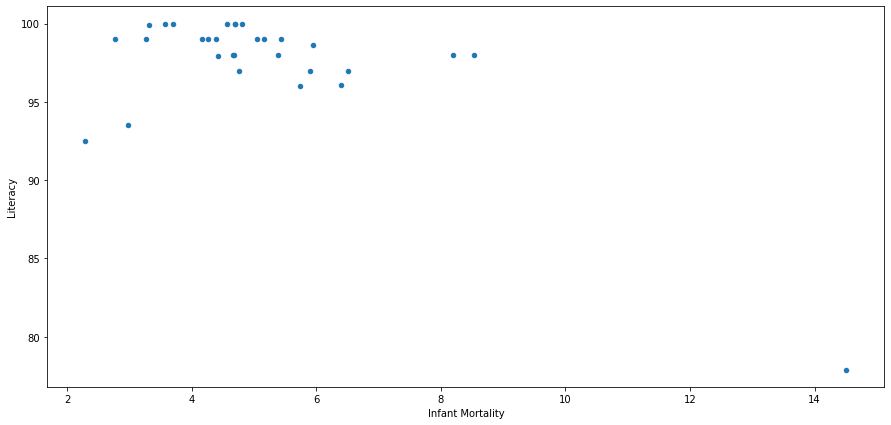

In [28]:
df_richest.plot.scatter(x="Infant Mortality", y="Literacy",figsize=(15,7))